## Equações de Bellman dos jogadores para o modelo de Dou et al (2019)

In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba as nb
from numba import jit, njit, jitclass, prange, float64, int32
%matplotlib inline


import time

### Parâmetros do jogo

In [3]:
μ = 4.566 #número de meses entre períodos, traduz a quantidade de períodos t em quantidade de meses
# ρ = 0.884 # (1 - ρ) é a taxa de depreciação da empresa a cada período
ρ = 0.5 #testando nova taxa de depreciação
β = 9.84 #usamos aqui a distribuição Uniforme, depois vamos mudar isto
c0 = 0.044 #custo fixo de ir para a corte
c1 = 0.015 #custo variável de ir para a corte


hs0 = 0.28 #habilidade inicial de s
hj0 = 0.36 #habilidade inicial de j

λj = 0.346



Valores que virão dos dados

In [4]:
Vmax = float64(1.0) #valor máximo de reorganização da firma
L = float64(0.25) #valor inicial de liquidação da firma
Ds = float64(0.28) #valor da dívida com credor sênior
Dj = float64(0.35) #valor da dívida com credor júnior

D = Ds + Dj #valor total da dívida, usada para escalar custos, por exemplo


Definições iniciais: custo, valores de liquidação, valor máximo de reorganização da firma a cada período, número de rounds

In [5]:
#função custo
def Ct(t):
    if(t == 0):
        return 0
    else:
        return c0 * D + c1 * t * D
    
#test
Ct(0)    
Ct(1)


0

0.037169999999999995

In [6]:
#number of periods
def max_turns(Vmax, L, ρ):
    t = 0
    
    while(ρ**(t-1) * Vmax - Ct(t) > L - Ct(t)):
        t += 1
    return t
#     T = (np.log(L) - np.log(Vmax))/np.log(ρ) + 1
    
#     return int32(T)

T = max_turns(Vmax, L, ρ)
T


#array com custos em cada período
C = np.empty(T)

for t in range(T):
    C[t] = Ct(t)

3

In [7]:
#value of the firm in each period

def Vt(Vmax, Tmax, ρ):
    
    V = np.empty(Tmax)
    
    V[0] = Vmax
    
    for t in range(1, Tmax):
        V[t] = Vmax * ρ**(t-1) - Ct(t)
        
    return V

V = Vt(Vmax, T, ρ)
V
    
        
        
    

array([1.     , 0.96283, 0.45338])

In [8]:
#valores de liquidação

def s_L(t):
    
    return np.minimum(L - Ct(t), Ds)

s_L(1)

def j_L(t):
    
    return np.minimum(L - Ct(t) - s_L(t), Dj)
    
j_L(0)

0.21283000000000002

0.0

Habilidades possíveis dos jogadores e funções de massa de probabilidade

In [9]:
#grid size
grid = 100

hlow = 0.01
hhigh = 1.0

#começa no menor valor possível, vai até o maior valor possível num intervalo do tamanho do grid
hvals = np.linspace(hlow, hhigh, grid)

hvals
hvals[6]


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

0.06999999999999999

Testando se o python consegue criar 2 x 10 arrays para os valores de continuação:
* 2 porque temos s e j
* 10 porque seria a quantidade de clusters

Se não conseguir, precisaremos pensar numa maneira de economizar memória no futuro

In [10]:
#test
test_W = np.zeros((2, 10, T, grid, grid, grid))

In [11]:
test_W.shape

(2, 10, 3, 100, 100, 100)

In [12]:
def cdf(x, lt):
    
    #return the cdf of x given the lower bound lt
    #geq than 1 because of our discretization method 
    if(x >=1):
        
        return 1
    
    else:
        
        if(x >= lt):
            return 1 - ((1-x)**β)/((1-lt)**β)
        else:
            return 0
        
#test      
cdf(0.5, 1)
cdf(0.5, 0.4)
            
cdf(0.99, 0.01)

cdf(1, 0.01)

cdf(1, 0.9)

0

0.8337136736331454

1.0

1

1

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.41624601e-02, 1.64810825e-01, 1.37355767e-01,
       1.14036220e-01, 9.42978761e-02, 7.76511534e-02, 6.36648020e-02,
      

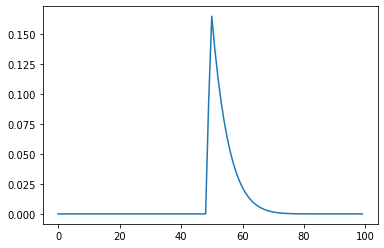

In [13]:
#nova versão da função pmf: agora cada ponto do grid é o centro da cdf
def pmf_cdf(lt, δ = hlow/2):
    
    pmf = np.empty(grid)
    
    
    for i, h in enumerate(hvals):
        pmf[i] = cdf(h+δ, lt) - cdf(h-δ, lt)
        
    return pmf


lt = 0.5
pmf_cdf(lt)
plt.plot(pmf_cdf(lt))

In [14]:
#gerando as pmfs

#probability mass function
pmf = np.empty((grid,grid))


for t, θt in enumerate(hvals):
    pmf[t,:] = pmf_cdf(θt)
    
#precisamos de uma pmf para quando temos lkt e queremos saber θk,t+1
#chamaremos de pmf2
pmf2 = np.empty((grid, grid))

for i in range(len(hvals)):
    for j in range(len(hvals)):
        pmf2[i, j] = np.sum(pmf[i, :] * pmf[:, j])


Arrays dos valores de continuação dos jogadores

In [15]:
#continuation values
#period, θkt, ℓkt, ℓmt
s_W = np.zeros((T, grid, grid, grid))
j_W = np.copy(s_W)


#optimal payments
#period, θkt, ℓmt, outputs
Pst_array = np.zeros((T, grid, grid, 6))
Pjt_array = np.copy(Pst_array)

In [16]:
#populating the last period with the liquidation values
s_W[(T-1), ...] = s_L(T)
j_W[(T-1), ...] = j_L(T)

Funções para calcular os valores de continuação dos jogadores

In [17]:
#função para mapear os valores das habilidades aos arrays
@njit
def find(h):
    
    return np.searchsorted(hvals, h)

find(hvals[7])
type(find(hvals[7]))

find(hvals)

#checando se temos valores repetidos
count = np.bincount(find(hvals))
np.where(count > 1)

7

int

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

(array([], dtype=int64),)

In [18]:
#cdf for the discretized distribution

def cdf_discrete(x, lt):
    #returns the probability that θt takes a value less than x, given lt
    #we use strictly less than x because now it is a discrete distribution
    return np.sum(pmf[find(lt), :find(x)])


#test
cdf(0.5, 0.01)
cdf_discrete(0.5, 0.01)

0.998795478578984

0.998671575594218

In [19]:
#array to tell us the size of the pie on next period
#arguments: (period, θk,t+1)
U = np.zeros((T, grid))

U = (hvals[:,None] * V[None,:] - C).T


#test
U[1,0] == hvals[0] * V[1] - Ct(1)


U[2,5] == hvals[5] * V[2] - Ct(2)

True

True

In [20]:
#função cutoff

@njit
def cutoff_m(t, Pkt, hkt, lmt, m_W):
    
    cmt = find(lmt)
    
    while(Pkt > m_W[t, cmt, cmt, find(hkt)] and hvals[cmt] < hhigh):
        cmt += 1
            
    
    #returns the index of the cutoff
    return max(int32(cmt), find(lmt))


cutoff_m(T-1, 0.01, 0.5, 0.4, j_W)

99

In [21]:
#function to select the correct pmf function given the cutoff


def h_m(t, cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
    #if cutoff > lmt, pmf[cutoff]
    #otherwise, pmf2[lmt]
    
    if(cutoff_m > lmt):
        return pmf[cutoff_m, lmt:] #'lmt:' is to make sure the dimensions are ok
    
    else:
        
        #at t=0, all information is symmetric, so we use pmf instead of pmf2
        if(t == 0):
            return pmf[lmt, lmt:]
        else:
            return pmf2[lmt, lmt:]
    

#test
#t != 0
h_m(1, 49,50) == pmf2[50, 50:]
h_m(1, 99, 50) == pmf[99, 50:]


#t == 0
h_m(0, 49, 50) == pmf[50, 50:]
h_m(0, 99, 50) == pmf[99, 50:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [22]:
#function to select the pmf function as it is writen in the paper


def h_m(t, cutoff_m, lmt):
    #takes the indexes of cutoff and lmt
    #if cutoff > lmt, pmf[cutoff]
    #otherwise, pmf2[lmt]
    
#     if(cutoff_m > lmt):
#         return pmf[cutoff_m, lmt:] #'lmt:' is to make sure the dimensions are ok

#     else:
        
        #at t=0, all information is symmetric, so we use pmf instead of pmf2
    if(t == 0):
        return pmf[lmt, lmt:]
    else:
        return pmf2[lmt, lmt:]

#test
#t != 0
h_m(1, 49,50) == pmf2[50, 50:]
h_m(1, 99, 50) == pmf[99, 50:]


#t == 0
h_m(0, 49, 50) == pmf[50, 50:]
h_m(0, 99, 50) == pmf[99, 50:]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [23]:
#função payoff ótimo

#retorna a política ótima também

def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    
    #grid of payments is the possible continuation values of the opponent
#     Pkt_grid = m_W[t, find(lmt):, find(lmt), find(hkt)]

    

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(hvals[find(lmt):].size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the continuation values of opponent
    Pkt_grid[1:] = m_W[t, find(lmt):, find(lmt), find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje ou o cutoff hoje
    
#     #shape is Pkt x M
#     probm = np.empty((Pkt_grid.size, hvals[find(lmt):].size))

#     for i in range(Pkt_grid.size):
#         probm[i] = h_m(cutoffs[i], find(lmt))

    
    
#     #multiplicando pE1 pelas probabilides das habilidades de k
#     pE1 = np.multiply(pE1, probk.T)
#     pE1 = np.sum(pE1, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE1 = np.multiply(pE1[:, None], probm)



    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]
    
    prob = np.outer(probk, probm)
    
    pE1 = np.dot(pE1, prob)
    
    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)
    
    
#     breakpoint()

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.dot(pE2, prob)
    
    #multiplicando pelas probabilides das habilidades de k
#     pE2 = np.multiply(pE2, probk.T)
#     pE2 = np.sum(pE2, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE2 = np.multiply(pE2[:, None], probm)
    
    
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)



(0.0, 59, 0.2009452145111204, 0.1939300000000001, 0.20338, 0)

In [24]:
#função payoff ótimo

#retorna a política ótima também

#Pkt versão 3: update na distribuição do cutoff de screen quando faz a proposta
def Pkt(t, hkt, lmt, k_W, m_W, k_L):
    

    

    #new grid of payments is the share of the pie tomorrow based on the hability today
    Pkt_grid = np.empty(hvals[find(lmt):].size + 1)
    
    #the first possible value is -Vmax, which is an offer so low that will be rejected for sure (waiting offer)
    Pkt_grid[0] = -Vmax
    
    #the other values are the continuation values of opponent
    Pkt_grid[1:] = m_W[t, find(lmt):, find(lmt), find(hkt)]
    
    
    cutoffs = int32(np.empty(Pkt_grid.shape))
    
    #loop for calculating the cutoffs
    for i, Pkt in enumerate(Pkt_grid):
        cutoffs[i] = cutoff_m(t, Pkt, hkt, lmt, m_W)
    
#     breakpoint()

    #cálculo de E1####
    
    #pE1[3,6] is the third possible payment combined with the sixth hability above hkt

    pE1 = np.array(U[t, None, find(hkt):] - Pkt_grid[:, None])
    
    
    #array com as probabilidades
    #probabiilidades de k amanhã dado a habilidade verdadeira hoje
    probk = pmf[find(hkt),find(hkt):]

    #probabilidade de m amanhã, dado o lower bound hoje ou o cutoff hoje
    
    #shape is Pkt x M
    probm = np.empty((Pkt_grid.size, hvals[find(lmt):].size))

    for i in range(Pkt_grid.size):
        probm[i] = h_m(t, cutoffs[i], find(lmt))

    
    
#     #multiplicando pE1 pelas probabilides das habilidades de k
    pE1 = np.multiply(pE1, probk[None, :])
    pE1 = np.sum(pE1, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE1 = np.multiply(pE1[:, None], probm)



    #ponderação pelas probabilidades
    pE1 = np.multiply(pE1[:, None], probm)
    
    #array indicador
    IE1 = np.where(m_W[t, find(lmt):, cutoffs, find(hkt)] <= Pkt_grid[:,None] , 1, 0)
    
    
#     breakpoint()

    #payoff de E1
    E1 = np.multiply(pE1, IE1)
    
    #soma ao longo das colunas (axis = 1) para que cada linha tenha o payoff esperado de propor um pagamento aceitável
    E1 = np.sum(E1, axis = 1)
    
    
    # #cálculo de E2####

    pE2 = k_W[t, find(hkt):, find(hkt), cutoffs]
    
    #multiplicando pE2 pelo array de probabilidades
    pE2 = np.multiply(pE2, probk[None, :])
    pE2 = np.sum(pE2, axis = 1)
    
    pE2 = np.multiply(pE2[:,None], probm)
    
    
    #multiplicando pelas probabilides das habilidades de k
#     pE2 = np.multiply(pE2, probk.T)
#     pE2 = np.sum(pE2, axis = 1)
    
#     #multiplicando agora pelas probabilidades das habilidades de m, dado cada Pkt
#     pE2 = np.multiply(pE2[:, None], probm)
    
    
    
    #array indicador de 
    IE2 = np.where(IE1 == 1, 0, 1)

    
    #payoff
    E2 = np.multiply(pE2, IE2)
    E2 = np.sum(E2, axis = 1)

    #matriz dos payoffs####
    matrix_payoff = E1 + E2

    payoff_reorg = np.max(matrix_payoff)
    index = np.argmax(matrix_payoff)

    pagamento = Pkt_grid[index]
    
    
    #calculating the optimal policy between liquidating, reorganizing or waiting ####
    payoff_liq = k_L(t)
    
    
    
    #waiting payoff is associated with the first possible payment, which is -Vmax, the waiting offer
    payoff_wait = matrix_payoff[0]
    
    
    
#     #avoiding numerical precision issues when comparing payoffs
#     if(np.allclose(payoff_wait, payoff_reorg, atol = 1e-15)):
#         #if the difference between waiting and reorganization payoff is small, then we use waiting payoff
#         payoff_max = np.max((payoff_liq, payoff_liq, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_liq, payoff_reorg))
#     else:
#         payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
#         policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))

    
    
    payoff_max = np.max((payoff_liq, payoff_wait, payoff_reorg))
    policy = np.argmax((payoff_liq, payoff_wait, payoff_reorg))
                         
    #retorna o payoff de esperar também para facilitar a verificação do código
    return pagamento, cutoffs[index], payoff_reorg, payoff_wait, payoff_max, policy
        

t, hkt, lmt, k_W, m_W, k_L = T-1, 0.5, 0.6, s_W, j_W, s_L
# share * U[t, find(hkt)]

Pkt(t, hkt, lmt, k_W, m_W, k_L)
# Pkt3(t, hkt, lmt, k_W, m_W, k_L)


(0.0, 59, 0.20094521451112046, 0.1939300000000002, 0.20338, 0)

In [25]:
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)


def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

In [26]:
#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [27]:
#checando se populou ok
t, h, l = T-1, 0.5, 0.5
Pst_array[t, find(h), find(l),:] == Pst(t, h, l)

array([ True,  True,  True,  True,  True,  True])

In [28]:
#função da proposta ótima


def propose(t, hkt, lkt, lmt, Pkt_array):
    #apenas busca o valor de Pkt
    
    payoff_max, policy = Pkt_array[t, find(hkt), find(lmt)][-2:]
    
    return payoff_max, policy

#test


t, hkt, lkt, lmt, Pkt_array = T-1, 0.5, 0.01, 0.5, Pst_array

Pst_array[t, find(hkt), find(lmt), :] = Pkt(t, hkt, lmt, k_W, m_W, k_L)

propose(t, hkt, lkt, lmt, Pkt_array)


(0.20338, 0.0)

In [29]:
#função de threshold

def threshold_m(t, lkt, lmt, Pmt_array):
    
    #procura onde a última entrada é diferente de 0 (policy de liquidar a firma)
    threshold_vector = np.array(np.where(Pmt_array[t, :, find(lkt), -1] != 0.0))
    
    if(threshold_vector.size == 0):
        #threshold does not exist
        ts = hhigh #will update lower bound to 1 just to accelerate the calculations
        probm_liq = 1.0
        
    else:
        ts = hvals[np.min(threshold_vector)]
    
        #probability that m will propose liquidation next period
        
        #if t == 0, the information is symmetric, thus ℓmt == θmt
        if(t == 0):
            if(lmt >= ts):
                probm_liq = 0.0
            else:
                probm_liq = 1
            
        #if t !=0, the information is asymmetric
        else:
            if(lmt >= ts):
                probm_liq = 0.0
            else:
                probm_liq = cdf_discrete(ts,lmt)

    #returns the reorganization threshold and the probability that m will propose liquidation in t
    return ts, probm_liq
    
    
 
t, lkt,lmt, Pmt_array = T-1, 0.5,0.51, Pst_array

Pmt_array[t, :, find(lkt), -1]

threshold_m(t, lkt,lmt,  Pmt_array)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

(0.51, 0.0)

In [30]:
#payoff esperado de responder a uma proposta de reorganização

def respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W):
    ts, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
    
    lmt = max(ts, lmt)
    
    
    #the possible values of payment given by the opponent
    Pmt_grid = Pmt_array[t, find(lmt):, find(lkt), 0]
    cutoffs = Pmt_array[t, find(lmt):, find(lkt), 1]
    cutoffs = int32(cutoffs)


    #A1### 
    
    #payoff quando receber pagamento é melhor respota
    pA1 = Pmt_grid

    #ponderação pelas probabilidades
    probk = pmf[find(hkt), find(hkt):]
    probm = pmf[find(lmt), find(lmt):]


    #primeiro vamos ver a função indicadora
    IA1 = np.where(k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T <= Pmt_grid, 1, 0)

    #IA1 tem S linhas e J colunas

    #queremos uma matriz de probabiidades com a mesma dimensão
    prob = np.outer(probk, probm)

    pA1 = np.multiply(pA1.T, prob)

    A1 = np.multiply(pA1, IA1)

    #A2####

    IA2 = np.where(IA1 == 1, 0, 1)

    pA2 = k_W[t, find(hkt):, cutoffs, np.arange(find(lmt), grid, step = 1)].T

    pA2 = np.multiply(pA2, prob)

    A2 = np.multiply(pA2, IA2)

    payoff = A1 + A2
    payoff = np.sum(payoff)

    #returns the expected value of answering a reorganization proposal and the probability of liquidation
    return payoff * (1.0 -probm_liq), probm_liq

#test1
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pjt_array, s_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)


lmt, probm_liq = threshold_m(t, lkt, lmt, Pmt_array)
Pjt(t, lmt, lkt)


#test2
t, hkt, lkt, lmt, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, Pst_array, j_W
respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)

Pst(t, lmt, lkt)


(0.1939300000000002, 0.0)

(0.19393, 49, 0.00290038897490738, 0.0, 0.00290038897490738, 2)

(0.0, 0.09416246009695162)

(0.0, 49, 0.20094521451112063, 0.19393000000000038, 0.20338, 0)

In [31]:
#payoff esperado de responder a uma proposta de liquidação

def respond_liq(t, hkt, lkt, lmt, k_L, m_L):
    
    #reorganiza pagando o valor de liquidação do oponente
    payoff_reorg = np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
    
    payoff_liq = k_L(t)
    
    return max(payoff_liq, payoff_reorg)

t, hkt, lkt, lmt, k_L, m_L = T-1, 0.5, 0.5, 0.5, s_L, j_L

respond_liq(t, hkt, lkt, lmt, k_L, m_L)
np.dot(pmf[find(hkt), find(hkt):], U[t, find(hkt):] - m_L(t))
k_L(t)

0.20338

0.20094521451112035

0.20338

In [32]:
#payoff esperado de responder
def respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L):
    
    payoff_rreorg, probm_liq = respond_reorg(t, hkt, lkt, lmt, Pmt_array, k_W)
    
    return payoff_rreorg + probm_liq * respond_liq(t, hkt, lkt, lmt, k_L, m_L)
    
t, hkt, lkt, lmt, k_L, m_L, Pmt_array, k_W = T-1, 0.5, 0.5, 0.5, s_L, j_L, Pst_array, j_W

respond(t, hkt, lkt, lmt, Pmt_array, k_W, k_L, m_L)


0.01915076113451802

In [33]:
#funções de s baseado nas funções genéricas
def Pst(t, θst, ℓjt):
    return Pkt(t, θst, ℓjt, s_W, j_W, s_L)

def s_propose(t, θst, ℓst, ℓjt):
    return propose(t, θst, ℓst, ℓjt, Pst_array)

def threshold_j(t, ℓst, ℓjt):
    return threshold_m(t, ℓst, ℓjt, Pjt_array)

def s_respond_reorg(t, θst, ℓst, ℓjt):
    return respond_reorg(t, θst, ℓst, ℓjt, Pjt_array, s_W)

def s_respond_liq(t, θst, ℓst, ℓjt):
    return respond_liq(t, θst, ℓst, ℓjt, s_L, j_L)
    
def s_respond(t, θst, ℓst, ℓjt):
    return respond(t, θst, ℓst, ℓjt, Pjt_array, s_W, s_L, j_L)


In [34]:
#funções de j baseado nas funções genéricas
def Pjt(t, θjt, ℓst):
    return Pkt(t, θjt, ℓst, j_W, s_W, j_L)

def j_propose(t, θjt, ℓjt, ℓst):
    return propose(t, θjt, ℓjt, ℓst, Pjt_array)

def threshold_s(t, ℓjt, ℓst):
    return threshold_m(t, ℓjt, ℓst, Pst_array)

def j_respond_reorg(t, θjt, ℓjt, ℓst):
    return respond_reorg(t, θjt, ℓjt, ℓst, Pst_array, j_W)

def j_respond_liq(t, θjt, ℓjt, ℓst):
    return respond_liq(t, θjt, ℓjt, ℓst, j_L, s_L)
    
def j_respond(t, θjt, ℓjt, ℓst):
    return respond(t, θjt, ℓjt, ℓst, Pst_array, j_W, j_L, s_L)

### Populando as matrizes do jogo

##### 1,2,3 Testando

In [35]:
t = (T-1)


start = time.process_time()

#populando as matrizes para continuar os testes

for h in hvals:
    for l in hvals:
            Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
            Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
            

duração = time.process_time() - start



print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para popular o período 2 : 6.34375


In [36]:
#testando funções
t, hkt, lkt, lmt = T-1, 0.6, 0.4, 0.5



In [37]:
s_propose(t, hkt, lkt, lmt)


threshold_j(t, ℓkt, ℓmt)
np.where(Pjt_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
s_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
s_respond_liq(t, hkt, lkt, lmt)
s_L(t)


#ok
s_respond(t, hkt, lkt, lmt)


#teste

s_respond(t, hkt, lkt, lmt) == s_respond_reorg(t, hkt, lkt, lmt)[0] + s_respond_reorg(t, hkt, lkt, lmt)[1] * s_respond_liq(t, hkt, lkt, lmt)

(0.24209147652152135, 2.0)

(0.49, 0.0)

(array([48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
        65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
        82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98,
        99], dtype=int64),)

respond_reorg


(0.19393000000000013, 0.0)

0.24209147652152102

0.20338

0.19393000000000013

True

In [38]:
j_propose(t, hkt, lkt, lmt)


#o threshold de ambos é para dar igual mesmo?
threshold_s(t, ℓkt, ℓmt)
np.where(Pst_array[t, :, find(lkt), -1] == 2)
#ok
print('respond_reorg')
j_respond_reorg(t, hkt, lkt, lmt)

#ok, e nesse caso s prefere liquidar a firma mesmo
j_respond_liq(t, hkt, lkt, lmt)
j_L(t)


#ok
j_respond(t, hkt, lkt, lmt)

#teste

j_respond(t, hkt, lkt, lmt) == j_respond_reorg(t, hkt, lkt, lmt)[0] + j_respond_reorg(t, hkt, lkt, lmt)[1] * j_respond_liq(t, hkt, lkt, lmt)

(0.04816147652152107, 2.0)

(0.51, 0.09416246009695162)

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
        67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
        84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),)

respond_reorg


(0.0, 0.09416246009695162)

0.03871147652152099

0.0

0.0036451678632517994

True

#### Populando todos os períodos

In [39]:


for t in range(T-1, 0, -1):

    start = time.process_time()

    #populando as matrizes para continuar os testes

    for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)
    print("tempo total para preparar o terreno do período", t, ":", time.process_time() - start)
    
    
    
    for i, hk in enumerate(hvals):
        for j, lk in enumerate(hvals):
            for k, lm in enumerate(hvals):
                s_W[(t-1), i, j, k] = λj * s_respond(t, hk, lk, lm) + (1-λj) * s_propose(t, hk, lk, lm)[0]
                j_W[(t-1), i, j, k] = λj * j_propose(t, hk, lk, lm)[0] + (1-λj) * j_respond(t, hk, lk, lm)


    duração = time.process_time() - start



    print("tempo total para popular o período", t, ":",time.process_time() - start)

tempo total para preparar o terreno do período 2 : 6.390625
tempo total para popular o período 2 : 277.890625
tempo total para preparar o terreno do período 1 : 6.609375
tempo total para popular o período 1 : 291.21875


In [40]:
#preparando o terreno no período 0 
t = 0

for h in hvals:
        for l in hvals:
                Pst_array[t, find(h), find(l), :] = Pst(t, h, l)
                Pjt_array[t, find(h), find(l), :] = Pjt(t, h, l)

In [41]:
#testando funções
t, hkt, lkt, lmt = 0, 0.6, 0.4, 0.5

Pst(t, hkt, lmt)
Pjt(t, hkt, lmt)

(0.12335018729181954,
 57,
 0.5030045447498569,
 0.4649071773041141,
 0.5030045447498569,
 2)

(0.41723554692389964,
 56,
 0.2004311409278142,
 0.14765955357039384,
 0.2004311409278142,
 2)

Salvando os dados

import os.path
date = '23_10'

np.save(os.path.join('Ws_array_'+date), s_W)
np.save(os.path.join('Wj_array_'+date), j_W)
np.save(os.path.join('Pst_array_'+date), Pst_array)
np.save(os.path.join('Pjt_array_'+date), Pjt_array)


Carregando os dados

#dia 17_10 foi o último dia com dados errados, ρ = 0.9xxx. Antes de corrigir o threshold
#dia 19_10 foi quando consertei o threshold, ρ = 0.5

import os.path
date = '22_10'

s_W = np.load(os.path.join('Ws_array_'+date+'.npy'))
j_W = np.load(os.path.join('Wj_array_'+date+'.npy'))
Pst_array = np.load(os.path.join('Pst_array_'+date+'.npy'))
Pjt_array = np.load(os.path.join('Pjt_array_'+date+'.npy'))


### Gráfico das funções

Gráfico das funções propose e respond

In [42]:
def graf_func(θ_vector, t, creditor,  function, ℓkt, ℓmt):
    #true hability increases while lower bounds stay at 0.5
    #t is also endogenous 
    
    fig, ax = plt.subplots()

    #size of X axis
    X = θ_vector


    #storing the function vals in t
    graf_vals = []

    for θt in θ_vector:
        function_val = function(t, θt, ℓkt, ℓmt)
        
        #for when we use the propose method, which returns a vector
        if(np.isscalar(function_val) == False):
            function_val = function_val[0]
            

        graf_vals.append(function_val)
        
        
#     label_val = repr(function)
    title_val = print(function, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt)

    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")

    ax.set_title(title_val)

    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()

No handles with labels found to put in legend.


<function s_propose at 0x000001FD80AFC708> ℓkt =  0.5 ℓmt =  0.5


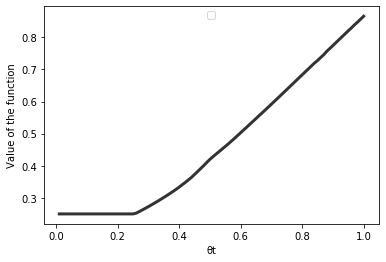

No handles with labels found to put in legend.


<function s_propose at 0x000001FD80AFC708> ℓkt =  0.3 ℓmt =  0.9


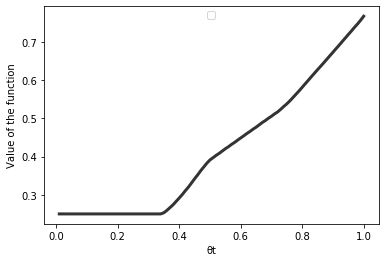

In [43]:
graf_func(hvals, 0, 's', s_propose, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_propose, ℓkt = 0.3, ℓmt = 0.9)

No handles with labels found to put in legend.


<function s_respond at 0x000001FD80AFC9D8> ℓkt =  0.5 ℓmt =  0.5


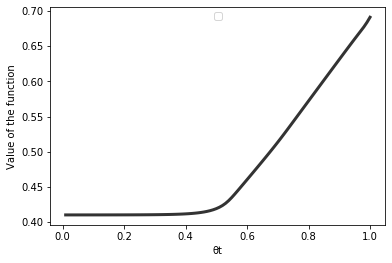

No handles with labels found to put in legend.


<function s_respond at 0x000001FD80AFC9D8> ℓkt =  0.3 ℓmt =  0.9


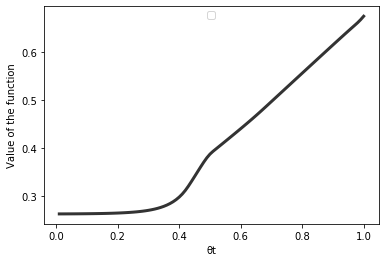

In [44]:
graf_func(hvals, 0, 's', s_respond, ℓkt = 0.5, ℓmt = 0.5)
graf_func(hvals, 0 , 's', s_respond, ℓkt = 0.3, ℓmt = 0.9)

Gráfico do valor de continuação

No handles with labels found to put in legend.


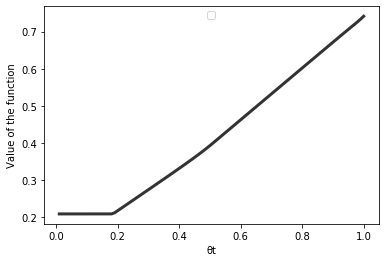

No handles with labels found to put in legend.


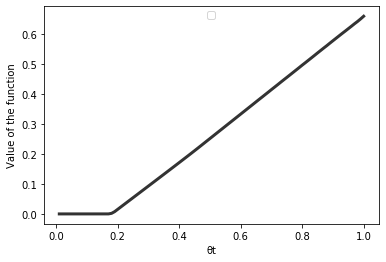

In [45]:
def graf_func_value(k_array, ℓkt, ℓmt, t):
    #t starts at t=1
    
    fig, ax = plt.subplots()

    #size of X axis
    X = hvals


    #storing the function vals in t
    graf_vals = k_array[(t-1), :, find(ℓkt), find(ℓmt)]


    ax.plot(X, graf_vals, '-k', linewidth = 3, alpha = 0.8)
    
#     name = str(k_array)
#     title_val = print(name, 'ℓkt = ', ℓkt, 'ℓmt = ', ℓmt, 'period = ', t)


    # ax.yaxis.tick_right()
    # ax.yaxis.set_ticks_position('both')

    #para mostrar ticks dos dois lados do eixo y



    plt.xlabel("θt")
    plt.ylabel("Value of the function")


    #achei melhor no upper right
    ax.legend(loc = 'upper center')
    plt.show()
    
graf_func_value(s_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

graf_func_value(j_W, ℓkt = 0.01, ℓmt = 0.02, t = 1)

Gráfico das propostas ótimas

In [46]:

def graf_proposal(function, function_name, t, xlabel, ylabel):
    

    grid_graf = len(hvals)

    graf = np.empty((grid_graf, grid_graf))

    for i, θs in enumerate(hvals):
        for j, lj in enumerate(hvals):
            graf[i,j] = function(t, θs, θs, lj)[1]


    fig, ax = plt.subplots()

    cs1 = ax.contourf(hvals, hvals, graf.T, alpha=0.75)
    # ctr1 = ax.contour(hvals, lj_vals, graf1.T)
    # plt.clabel(ctr1, inline=1, fontsize=13)
    plt.colorbar(cs1, ax = ax)

    ax.set_title('Function ' + function_name +   ' in period ' + str(t) )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    ax.ticklabel_format(useOffset=False)


    plt.show()

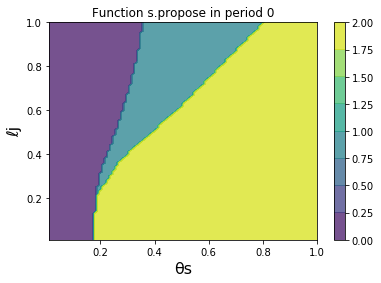

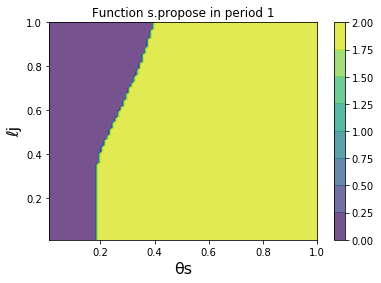

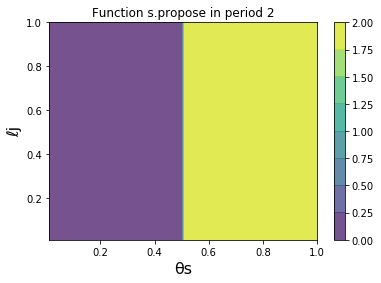

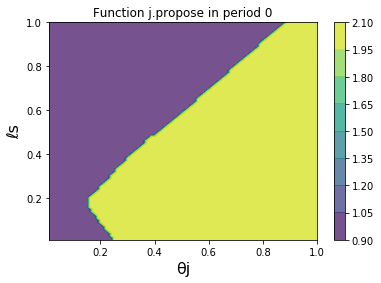

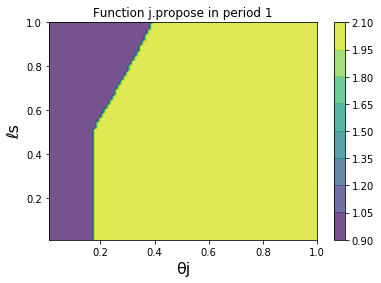

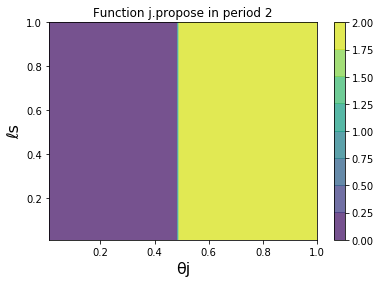

In [47]:
graf_proposal(s_propose,'s.propose', 0, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 1, 'θs', 'ℓj')

graf_proposal(s_propose,'s.propose', 2, 'θs', 'ℓj')

graf_proposal(j_propose, 'j.propose', 0, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 1, 'θj', 'ℓs')
graf_proposal(j_propose, 'j.propose', 2, 'θj', 'ℓs')

#### Checando função propose nos locais onde ela está estranha

In [48]:
def check_proposal(t, fixed_param, fixed_val, low, high, Pkt):
    #fixed parameter = lm or hk
    
    if(fixed_param == 'hk'):
        for i in range(find(low), find(high)):
            print(Pkt(t, fixed_val, hvals[i]), i)
        
        
    else:
        for i in range(find(low), find(high)):
            print(Pkt(t, hvals[i], fixed_val ), i)
    
    
#test
check_proposal(2, 'lm', 0.8, 0.4, 0.5, Pjt)

(-1.0, 79, 0.0, 0.0, 0.0, 0) 39
(-1.0, 79, 0.0, 0.0, 0.0, 0) 40
(-1.0, 79, 0.0, 0.0, 0.0, 0) 41
(-1.0, 79, 0.0, 0.0, 0.0, 0) 42
(-1.0, 79, 0.0, 0.0, 0.0, 0) 43
(-1.0, 79, 0.0, 0.0, 0.0, 0) 44
(-1.0, 79, 0.0, 0.0, 0.0, 0) 45
(-1.0, 79, 0.0, 0.0, 0.0, 0) 46
(-1.0, 79, 0.0, 0.0, 0.0, 0) 47
(0.19393, 79, 0.0029003889749073812, 0.0, 0.0029003889749073812, 2) 48


1) Valores de S na espera. hk = 0.2 e lm variando de 0.2 a 0.5. Conclusão: o payoff de liquidar realmente fica mais alto a partir de um certo nível de lmt

In [49]:
hvals[20]

0.21000000000000002

In [50]:
check_proposal(0, 'hk', 0.2, 0.01, 0.5, Pst)

(0.0019347684096833958, 17, 0.2694737255305679, 0.2602781200545634, 0.2694737255305679, 2) 0
(0.0019347684096833958, 17, 0.2692277797616891, 0.26021602660358034, 0.2692277797616891, 2) 1
(0.0019347684096833958, 17, 0.2689530643685062, 0.26014776621082536, 0.2689530643685062, 2) 2
(0.0019347684096833958, 17, 0.2686458637811287, 0.26007267269944523, 0.2686458637811287, 2) 3
(0.0019347684096833958, 17, 0.2683019363464708, 0.2599900026548557, 0.2683019363464708, 2) 4
(0.0019347684096833958, 17, 0.2679164331517261, 0.25989892596203923, 0.2679164331517261, 2) 5
(0.0019347684096833958, 17, 0.2674838032668061, 0.2597985151439679, 0.2674838032668061, 2) 6
(0.0019347684096833958, 17, 0.2669976829530712, 0.25968773334977613, 0.2669976829530712, 2) 7
(0.0019347684096846511, 17, 0.2664507659093956, 0.25956542082380996, 0.2664507659093956, 2) 8
(0.0019347688577698438, 17, 0.2658346507934589, 0.2594302796722477, 0.2658346507934589, 2) 9
(0.0019348159043632292, 17, 0.26513963864615564, 0.2592808577269

2) Valores de J propondo liquidar em T-1

lmt não importa, mas hk varia entre 0.4 e 0.5

Conclusão: de fato antes do threshold de j, a proposta ótima era esperar. E esperar tem o mesmo payoff de liquidar, então ele propõe liquidar logo.

Além disso, o threshold de reorg é maior para S do que para J. Faz sentido porque a outside option de S dá payoff maior que a outside option de J.

In [51]:
check_proposal(T-1, 'lm', 0.01, 0.4, 0.5, Pjt)

(-1.0, 0, 0.0, 0.0, 0.0, 0) 39
(-1.0, 0, 0.0, 0.0, 0.0, 0) 40
(-1.0, 0, 0.0, 0.0, 0.0, 0) 41
(-1.0, 0, 0.0, 0.0, 0.0, 0) 42
(-1.0, 0, 0.0, 0.0, 0.0, 0) 43
(-1.0, 0, 0.0, 0.0, 0.0, 0) 44
(-1.0, 0, 0.0, 0.0, 0.0, 0) 45
(-1.0, 0, 0.0, 0.0, 0.0, 0) 46
(-1.0, 0, 0.0, 0.0, 0.0, 0) 47
(0.19393, 0, 0.0029003889749073773, 0.0, 0.0029003889749073773, 2) 48


In [52]:
check_proposal(T-1, 'lm', 0.01, 0.4, 0.6, Pst)

(-1.0, 0, 0.19393000000000027, 0.19393000000000027, 0.20338, 0) 39
(-1.0, 0, 0.19393000000000024, 0.19393000000000024, 0.20338, 0) 40
(-1.0, 0, 0.19393000000000024, 0.19393000000000024, 0.20338, 0) 41
(-1.0, 0, 0.1939300000000003, 0.1939300000000003, 0.20338, 0) 42
(-1.0, 0, 0.19393000000000035, 0.19393000000000035, 0.20338, 0) 43
(-1.0, 0, 0.1939300000000004, 0.1939300000000004, 0.20338, 0) 44
(-1.0, 0, 0.19393000000000046, 0.19393000000000046, 0.20338, 0) 45
(-1.0, 0, 0.19393000000000052, 0.19393000000000052, 0.20338, 0) 46
(-1.0, 0, 0.19393000000000057, 0.19393000000000057, 0.20338, 0) 47
(0.0, 0, 0.1968303889749076, 0.19393000000000024, 0.20338, 0) 48
(0.0, 0, 0.2009452145111205, 0.19393000000000024, 0.20338, 0) 49
(0.0, 0, 0.20506001043798494, 0.19393000000000024, 0.20506001043798494, 2) 50
(0.0, 0, 0.20917477491123462, 0.19393000000000024, 0.20917477491123462, 2) 51
(0.0, 0, 0.21328950593033735, 0.1939300000000003, 0.21328950593033735, 2) 52
(0.0, 0, 0.21740420132160307, 0.193930

In [53]:
#thresholds
print('threshold de J em T-1: ', hvals[48])

print('threshold de S em T-1: ', hvals[50])

threshold de J em T-1:  0.49
threshold de S em T-1:  0.51


3) Proposta de j em t=0

lm variando de 0.01 a 0.2, enquanto hk = 0.2

Quero ver porque tem aquela "barriga" no gráfico

In [54]:
check_proposal(0, 'hk', 0.2, 0.01, 0.2, Pjt)

(-1.0, 0, 0.07375679105854385, 0.07375679105854385, 0.07375679105854385, 1) 0
(-1.0, 1, 0.0729600146356922, 0.0729600146356922, 0.0729600146356922, 1) 1
(-1.0, 2, 0.07207042027045596, 0.07207042027045596, 0.07207042027045596, 1) 2
(-1.0, 3, 0.07107606640563134, 0.07107606640563134, 0.07107606640563134, 1) 3
(-1.0, 4, 0.06996332674042652, 0.06996332674042652, 0.06996332674042652, 1) 4
(-1.0, 5, 0.06871663109364422, 0.06871663109364422, 0.06871663109364422, 1) 5
(-1.0, 6, 0.0673181630982065, 0.0673181630982065, 0.0673181630982065, 1) 6
(-1.0, 7, 0.06574750687293697, 0.06574750687293697, 0.06574750687293697, 1) 7
(0.20949673816764186, 8, 0.06399556265282424, 0.06398123344928568, 0.06399556265282424, 2) 8
(0.20949852982180905, 9, 0.062112895453718, 0.061992415805523234, 0.062112895453718, 2) 9
(0.20950055083641034, 10, 0.05999267632067551, 0.05975005926441508, 0.05999267632067551, 2) 10
(0.20950283429166258, 11, 0.057601650282864014, 0.057218430931496186, 0.057601650282864014, 2) 11
(0.209

Suspeita é que o grid de pagamentos não esteja fino o suficiente...

In [55]:
s_W[0, :, 8, find(0.2)]

array([0.20948795, 0.20948866, 0.20948946, 0.20949035, 0.20949135,
       0.20949248, 0.20949373, 0.20949515, 0.20949674, 0.20949853,
       0.20950055, 0.20950283, 0.20950542, 0.20950834, 0.20951166,
       0.20951543, 0.20951972, 0.2095246 , 0.21204308, 0.217366  ,
       0.22268996, 0.22801513, 0.2333417 , 0.23866992, 0.24400006,
       0.24933244, 0.25466745, 0.26000556, 0.26534731, 0.27069337,
       0.27608156, 0.28149482, 0.28691489, 0.29234307, 0.29780566,
       0.30330542, 0.308819  , 0.31434926, 0.31989966, 0.3254745 ,
       0.33107905, 0.33671988, 0.34240513, 0.34814498, 0.35395215,
       0.35984268, 0.36590174, 0.3721356 , 0.37854679, 0.38533483,
       0.39247372, 0.39934479, 0.40621578, 0.41308671, 0.41995755,
       0.42682832, 0.43369899, 0.44056957, 0.44744794, 0.45433604,
       0.46122403, 0.46811189, 0.47499962, 0.48188719, 0.4887746 ,
       0.49566183, 0.50254888, 0.50943668, 0.5163384 , 0.52323986,
       0.53014104, 0.5370419 , 0.54394243, 0.55084257, 0.55774

Anotações anteriores

In [56]:
#hk fixa e lm variando
t = 0
lm = 0.01
hk = 0.61

for i in range(find(0.01), find(0.3)):
    (Pst(t, hk, hvals[i])[2] - Pst(t, hk, hvals[i])[3])/Pst(t, hk, hvals[i])[3], Pst(t, hk, hvals[i] )[-1], i

(0.2633300186048015, 2, 0)

(0.2619906817856147, 2, 1)

(0.2604819557556801, 2, 2)

(0.2587803044131165, 2, 3)

(0.25685860813221256, 2, 4)

(0.2546855668047455, 2, 5)

(0.2522249941458698, 2, 6)

(0.24986402499336227, 2, 7)

(0.24740372245287826, 2, 8)

(0.24504636861837797, 2, 9)

(0.24243699453615622, 2, 10)

(0.24187790351326077, 2, 11)

(0.23788216928089895, 2, 12)

(0.23441180765527944, 2, 13)

(0.2353074926447587, 2, 14)

(0.231346172133495, 2, 15)

(0.22755829551757006, 2, 16)

(0.2230178226105253, 2, 17)

(0.2190694457331037, 2, 18)

(0.21634707894084437, 2, 19)

(0.21433229328416764, 2, 20)

(0.21052748656552203, 2, 21)

(0.20537556124626694, 2, 22)

(0.20065522929865567, 2, 23)

(0.19534645992169347, 2, 24)

(0.18977994127248266, 2, 25)

(0.18460974096046234, 2, 26)

(0.17857608020420032, 2, 27)

(0.1775198462957683, 2, 28)

2) Quando lm está fixo e hk varia

In [57]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    Pst(t, hvals[i], lm )[2] - Pst(t, hvals[i], lm )[3], Pst(0, hvals[i], lm )[-1], i

(0.0, 0, 19)

(0.0, 0, 20)

(0.0, 0, 21)

(0.0, 0, 22)

(0.0, 0, 23)

(0.0, 0, 24)

(0.0, 0, 25)

(0.0, 0, 26)

(0.0, 0, 27)

(0.0, 0, 28)

(0.0, 0, 29)

(0.0, 0, 30)

(0.0, 0, 31)

(0.0, 1, 32)

(0.0, 1, 33)

(0.0, 1, 34)

(0.0, 1, 35)

(0.0, 1, 36)

(0.0, 1, 37)

(0.0, 1, 38)

(0.0, 1, 39)

(0.0, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(0.0, 1, 45)

(0.0, 1, 46)

(0.0, 1, 47)

(0.0, 1, 48)

In [58]:
#hk variando e lm fixa

#quero ver os cutoffs agora

t = 0
lm = 0.8
low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pst(t, hvals[i], lm )

(0, (-1.0, 79, 0.20916795229259572, 0.20916795229259572, 0.25, 0))

(1, (-1.0, 79, 0.20924508411391657, 0.20924508411391657, 0.25, 0))

(2, (-1.0, 79, 0.20933118465967726, 0.20933118465967726, 0.25, 0))

(3, (-1.0, 79, 0.2094274058344844, 0.2094274058344844, 0.25, 0))

(4, (-1.0, 79, 0.20953506179975145, 0.20953506179975145, 0.25, 0))

(5, (-1.0, 79, 0.2096556538895636, 0.2096556538895636, 0.25, 0))

(6, (-1.0, 79, 0.20979089967604897, 0.20979089967604897, 0.25, 0))

(7, (-1.0, 79, 0.20994276693040745, 0.20994276693040745, 0.25, 0))

(8, (-1.0, 79, 0.21011351337004897, 0.21011351337004897, 0.25, 0))

(9, (-1.0, 79, 0.2103057332565121, 0.2103057332565121, 0.25, 0))

(10, (-1.0, 79, 0.21052241212006478, 0.21052241212006478, 0.25, 0))

(11, (-1.0, 79, 0.211002560235363, 0.211002560235363, 0.25, 0))

(12, (-1.0, 79, 0.21127845263409467, 0.21127845263409467, 0.25, 0))

(13, (-1.0, 79, 0.2115907502809853, 0.2115907502809853, 0.25, 0))

(14, (-1.0, 79, 0.21197026359247403, 0.21197026359247403, 0.25, 0))

(15, (-1.0, 79, 0.2123720951441708, 0.2123720951441708, 0.25, 0))

(16, (-1.0, 79, 0.21300278688276272, 0.21300278688276272, 0.25, 0))

(17, (-1.0, 79, 0.21398621932314577, 0.21398621932314577, 0.25, 0))

(18, (-1.0, 79, 0.21520580456534255, 0.21520580456534255, 0.25, 0))

(19, (-1.0, 79, 0.21605816216304183, 0.21605816216304183, 0.25, 0))

(20, (-1.0, 79, 0.2181912335270264, 0.2181912335270264, 0.25, 0))

(21, (-1.0, 79, 0.21976141241697833, 0.21976141241697833, 0.25, 0))

(22, (-1.0, 79, 0.2210368080745483, 0.2210368080745483, 0.25, 0))

(23, (-1.0, 79, 0.22302002072466245, 0.22302002072466245, 0.25, 0))

(24, (-1.0, 79, 0.22476520390640006, 0.22476520390640006, 0.25, 0))

(25, (-1.0, 79, 0.22681745401394807, 0.22681745401394807, 0.25, 0))

(26, (-1.0, 79, 0.2294534361499979, 0.2294534361499979, 0.25, 0))

(27, (-1.0, 79, 0.23174701791809035, 0.23174701791809035, 0.25, 0))

(28, (-1.0, 79, 0.23479817294589114, 0.23479817294589114, 0.25, 0))

(29, (-1.0, 79, 0.2384663313292952, 0.2384663313292952, 0.25, 0))

(30, (-1.0, 79, 0.24177404955458545, 0.24177404955458545, 0.25, 0))

(31, (-1.0, 79, 0.24638863604922331, 0.24638863604922331, 0.25, 0))

(32, (-1.0, 79, 0.2515265892120241, 0.2515265892120241, 0.2515265892120241, 1))

(33, (-1.0, 79, 0.2569541938564029, 0.2569541938564029, 0.2569541938564029, 1))

(34, (-1.0, 79, 0.2637808619526683, 0.2637808619526683, 0.2637808619526683, 1))

(35, (-1.0, 79, 0.270447256295833, 0.270447256295833, 0.270447256295833, 1))

(36,
 (-1.0, 79, 0.27787132055990027, 0.27787132055990027, 0.27787132055990027, 1))

(37, (-1.0, 79, 0.2858636962608422, 0.2858636962608422, 0.2858636962608422, 1))

(38, (-1.0, 79, 0.2933582310506248, 0.2933582310506248, 0.2933582310506248, 1))

(39, (-1.0, 79, 0.3019400240703745, 0.3019400240703745, 0.3019400240703745, 1))

(40,
 (-1.0, 79, 0.31046066343962403, 0.31046066343962403, 0.31046066343962403, 1))

(41, (-1.0, 79, 0.319405401503426, 0.319405401503426, 0.319405401503426, 1))

(42,
 (-1.0, 79, 0.32905318604361605, 0.32905318604361605, 0.32905318604361605, 1))

(43, (-1.0, 79, 0.3382541090346707, 0.3382541090346707, 0.3382541090346707, 1))

(44, (-1.0, 79, 0.348341993650502, 0.348341993650502, 0.348341993650502, 1))

(45, (-1.0, 79, 0.3587018539862133, 0.3587018539862133, 0.3587018539862133, 1))

(46, (-1.0, 79, 0.3681640943970248, 0.3681640943970248, 0.3681640943970248, 1))

(47,
 (-1.0, 79, 0.37818733724248793, 0.37818733724248793, 0.37818733724248793, 1))

(48,
 (-1.0, 79, 0.38690603802835044, 0.38690603802835044, 0.38690603802835044, 1))

(49, (-1.0, 79, 0.3947652613582588, 0.3947652613582588, 0.3947652613582588, 1))

(50,
 (-1.0, 79, 0.40145630039352204, 0.40145630039352204, 0.40145630039352204, 1))

(51, (-1.0, 79, 0.4066704580622582, 0.4066704580622582, 0.4066704580622582, 1))

(52, (-1.0, 79, 0.4127182621998631, 0.4127182621998631, 0.4127182621998631, 1))

(53, (-1.0, 79, 0.4183173538306469, 0.4183173538306469, 0.4183173538306469, 1))

(54,
 (-1.0, 79, 0.42398142903316555, 0.42398142903316555, 0.42398142903316555, 1))

(55, (-1.0, 79, 0.4300666660528895, 0.4300666660528895, 0.4300666660528895, 1))

(56, (-1.0, 79, 0.4352795486515575, 0.4352795486515575, 0.4352795486515575, 1))

(57, (-1.0, 79, 0.4413272051919556, 0.4413272051919556, 0.4413272051919556, 1))

(58, (-1.0, 79, 0.4469255163163205, 0.4469255163163205, 0.4469255163163205, 1))

In [59]:
#hk variando e lm fixa
t = 0
lm = hvals[9]

low = 0.2
high = 0.5

for i in range(find(low), find(high)):
    i,Pst(t, hvals[i], lm )

(19,
 (0.0019347688577698438,
  17,
  0.2658346507934589,
  0.2594302796722477,
  0.2658346507934589,
  2))

(20,
 (0.0019242315806075468,
  17,
  0.27316605636677505,
  0.26452661642710906,
  0.27316605636677505,
  2))

(21,
 (0.001912467171026802,
  17,
  0.28050287312426214,
  0.26962994082001795,
  0.28050287312426214,
  2))

(22,
 (0.0018993242211769671,
  17,
  0.2878463662509911,
  0.27474168179271286,
  0.2878463662509911,
  2))

(23,
 (0.0018846322571687486,
  17,
  0.29519238506039924,
  0.27985819753767305,
  0.29519238506039924,
  2))

(24,
 (0.0018681994759084091,
  17,
  0.3025505282936659,
  0.2849888318198085,
  0.3025505282936659,
  2))

(25,
 (0.0018498102930168308,
  17,
  0.30991205410945644,
  0.2901256914526858,
  0.30991205410945644,
  2))

(26,
 (0.004548615375619418,
  18,
  0.31747538709297657,
  0.295279719844414,
  0.31747538709297657,
  2))

(27,
 (0.004489460001471381,
  18,
  0.3250690735199675,
  0.30044331836852406,
  0.3250690735199675,
  2))

(28,
 (0.007068120196905078,
  19,
  0.3328434989361052,
  0.3056250279374884,
  0.3328434989361052,
  2))

(29,
 (0.006948580296202148,
  19,
  0.34067512183488946,
  0.3108252897861278,
  0.34067512183488946,
  2))

(30,
 (0.00936591386799339,
  20,
  0.34868460951388414,
  0.3160514391634343,
  0.34868460951388414,
  2))

(31,
 (0.009159055179422929,
  20,
  0.356768884928619,
  0.32130471087581486,
  0.356768884928619,
  2))

(32,
 (0.011360941722810259,
  21,
  0.3650183034274299,
  0.3265691361367234,
  0.3650183034274299,
  2))

(33,
 (0.011030528773204012,
  21,
  0.3733764337901534,
  0.33189241039551143,
  0.3733764337901534,
  2))

(34,
 (0.01068205079146595,
  21,
  0.3817535450701314,
  0.3372470878973739,
  0.3817535450701314,
  2))

(35,
 (0.008054985017180613,
  20,
  0.38946852211769767,
  0.34263191416974426,
  0.38946852211769767,
  2))

(36,
 (0.016619533823219016,
  23,
  0.3973778740945521,
  0.3480597704311051,
  0.3973778740945521,
  2))

(37,
 (0.01588685612787297,
  23,
  0.40638855086266223,
  0.35356018157922287,
  0.40638855086266223,
  2))

(38,
 (0.01726754161778087,
  24,
  0.4154599143575835,
  0.35910114212810124,
  0.4154599143575835,
  2))

(39,
 (0.014341946015648305,
  23,
  0.42445507144427197,
  0.3646667046667991,
  0.42445507144427197,
  2))

(40,
 (0.017910271754168688,
  24,
  0.43198091426603225,
  0.37034382277989075,
  0.43198091426603225,
  2))

(41,
 (0.01710693876908672,
  24,
  0.4411499621205691,
  0.37601749528490813,
  0.4411499621205691,
  2))

(42,
 (0.016304240461097224,
  24,
  0.4503234275197934,
  0.38176533463488527,
  0.4503234275197934,
  2))

(43,
 (0.017747774981097385,
  25,
  0.4596032041395193,
  0.3876050453845659,
  0.4596032041395193,
  2))

(44,
 (0.01262341587762474,
  23,
  0.46811607228620766,
  0.3934904423879053,
  0.46811607228620766,
  2))

(45,
 (0.01842590038348101,
  25,
  0.4762814172560704,
  0.39944552587219906,
  0.4762814172560704,
  2))

(46,
 (0.017635510303676865,
  25,
  0.48562429810911484,
  0.4054731257632613,
  0.48562429810911484,
  2))

(47,
 (0.014571651518833917,
  24,
  0.49459775669314615,
  0.41155776941151084,
  0.49459775669314615,
  2))

(48,
 (0.018347021047904397,
  26,
  0.5022845526216805,
  0.4176682470493062,
  0.5022845526216805,
  2))

II) Analisado j_propose em t = 0

1) Checando quando lm = 0.01 e hk varia entre 0.2 e 0.4. 

In [60]:
#hk variando e lm fixa
t = 0
lm = 0.01

low = 0.2
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(9.701932820183057e-07, 2, 24)

(9.307023624748056e-05, 2, 25)

(0.00018460939631820272, 2, 26)

(0.0002763126113579373, 2, 27)

(0.0003669908107249986, 2, 28)

(0.0004582936499412382, 2, 29)

(0.0005479451846609751, 2, 30)

(0.0006378975828038869, 2, 31)

(0.000726590074427047, 2, 32)

(0.0008154512640263234, 2, 33)

(0.0010830748943341795, 2, 34)

(0.0017245553961382776, 2, 35)

(0.0025852086540728847, 2, 36)

(0.003381753200473958, 2, 37)

(0.003980493624288789, 2, 38)

2) Checando quando ls = 0.8 e hk varia de 0.01 até 0.6

In [61]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    i, Pjt(t, hvals[i], lm )

(0,
 (-1.0,
  79,
  0.0005022348489998888,
  0.0005022348489998888,
  0.0005022348489998888,
  1))

(1,
 (-1.0,
  79,
  0.0005537398677573767,
  0.0005537398677573767,
  0.0005537398677573767,
  1))

(2,
 (-1.0,
  79,
  0.0006111352249948586,
  0.0006111352249948586,
  0.0006111352249948586,
  1))

(3,
 (-1.0,
  79,
  0.0006751656619828014,
  0.0006751656619828014,
  0.0006751656619828014,
  1))

(4,
 (-1.0,
  79,
  0.0007466792674977757,
  0.0007466792674977757,
  0.0007466792674977757,
  1))

(5,
 (-1.0,
  79,
  0.0008266431224302043,
  0.0008266431224302043,
  0.0008266431224302043,
  1))

(6,
 (-1.0,
  79,
  0.0009161615143349468,
  0.0009161615143349468,
  0.0009161615143349468,
  1))

(7,
 (-1.0,
  79,
  0.0010164971779699533,
  0.0010164971779699533,
  0.0010164971779699533,
  1))

(8,
 (-1.0,
  79,
  0.0011290971464106658,
  0.0011290971464106658,
  0.0011290971464106658,
  1))

(9,
 (-1.0,
  79,
  0.0016266654437640618,
  0.0016266654437640618,
  0.0016266654437640618,
  1))

(10,
 (-1.0,
  79,
  0.003928892977305112,
  0.003928892977305112,
  0.003928892977305112,
  1))

(11,
 (-1.0,
  79,
  0.004923204545481294,
  0.004923204545481294,
  0.004923204545481294,
  1))

(12,
 (-1.0,
  79,
  0.005518421181440774,
  0.005518421181440774,
  0.005518421181440774,
  1))

(13,
 (-1.0,
  79,
  0.006220398391966211,
  0.006220398391966211,
  0.006220398391966211,
  1))

(14,
 (-1.0,
  79,
  0.007333974534148232,
  0.007333974534148232,
  0.007333974534148232,
  1))

(15,
 (-1.0,
  79,
  0.007654633338113092,
  0.007654633338113092,
  0.007654633338113092,
  1))

(16,
 (-1.0,
  79,
  0.008775080611008549,
  0.008775080611008549,
  0.008775080611008549,
  1))

(17,
 (-1.0,
  79,
  0.009514689192116382,
  0.009514689192116382,
  0.009514689192116382,
  1))

(18,
 (-1.0,
  79,
  0.010372590230325248,
  0.010372590230325248,
  0.010372590230325248,
  1))

(19,
 (-1.0,
  79,
  0.011687958043304263,
  0.011687958043304263,
  0.011687958043304263,
  1))

(20,
 (-1.0,
  79,
  0.012228977527411098,
  0.012228977527411098,
  0.012228977527411098,
  1))

(21,
 (-1.0, 79, 0.01360381027209335, 0.01360381027209335, 0.01360381027209335, 1))

(22,
 (-1.0,
  79,
  0.014639715124455444,
  0.014639715124455444,
  0.014639715124455444,
  1))

(23,
 (-1.0, 79, 0.01584022001851308, 0.01584022001851308, 0.01584022001851308, 1))

(24,
 (-1.0,
  79,
  0.017554162147368237,
  0.017554162147368237,
  0.017554162147368237,
  1))

(25,
 (-1.0,
  79,
  0.018522531799127287,
  0.018522531799127287,
  0.018522531799127287,
  1))

(26,
 (-1.0, 79, 0.02047428384675493, 0.02047428384675493, 0.02047428384675493, 1))

(27,
 (-1.0,
  79,
  0.021963807026303395,
  0.021963807026303395,
  0.021963807026303395,
  1))

(28,
 (-1.0, 79, 0.02407985279014444, 0.02407985279014444, 0.02407985279014444, 1))

(29,
 (-1.0, 79, 0.02666969548203331, 0.02666969548203331, 0.02666969548203331, 1))

(30,
 (-1.0, 79, 0.02864202072756871, 0.02864202072756871, 0.02864202072756871, 1))

(31,
 (-1.0, 79, 0.03179498672277472, 0.03179498672277472, 0.03179498672277472, 1))

(32,
 (-1.0, 79, 0.03446596479566008, 0.03446596479566008, 0.03446596479566008, 1))

(33,
 (-1.0, 79, 0.03800150016359148, 0.03800150016359148, 0.03800150016359148, 1))

(34,
 (-1.0, 79, 0.04164889855705614, 0.04164889855705614, 0.04164889855705614, 1))

(35,
 (-1.0,
  79,
  0.044946029636496874,
  0.044946029636496874,
  0.044946029636496874,
  1))

(36,
 (-1.0, 79, 0.04907444327442979, 0.04907444327442979, 0.04907444327442979, 1))

(37,
 (-1.0,
  79,
  0.052490782060043276,
  0.052490782060043276,
  0.052490782060043276,
  1))

(38,
 (-1.0, 79, 0.05679260425353961, 0.05679260425353961, 0.05679260425353961, 1))

(39,
 (-1.0,
  79,
  0.060601183231649036,
  0.060601183231649036,
  0.060601183231649036,
  1))

(40, (-1.0, 79, 0.0649394111924267, 0.0649394111924267, 0.0649394111924267, 1))

(41,
 (-1.0, 79, 0.06961535632426215, 0.06961535632426215, 0.06961535632426215, 1))

(42,
 (-1.0, 79, 0.07344492586775267, 0.07344492586775267, 0.07344492586775267, 1))

(43,
 (-1.0, 79, 0.07821198637420289, 0.07821198637420289, 0.07821198637420289, 1))

(44,
 (-1.0, 79, 0.08214083815541942, 0.08214083815541942, 0.08214083815541942, 1))

(45,
 (-1.0, 79, 0.08676077107442887, 0.08676077107442887, 0.08676077107442887, 1))

(46,
 (-1.0, 79, 0.09076979333041783, 0.09076979333041783, 0.09076979333041783, 1))

(47, (-1.0, 79, 0.0944986879843458, 0.0944986879843458, 0.0944986879843458, 1))

(48,
 (-1.0, 79, 0.09828489740691455, 0.09828489740691455, 0.09828489740691455, 1))

(49,
 (-1.0, 79, 0.10100431891907866, 0.10100431891907866, 0.10100431891907866, 1))

(50,
 (-1.0, 79, 0.10463894683862125, 0.10463894683862125, 0.10463894683862125, 1))

(51,
 (-1.0, 79, 0.10739603729466203, 0.10739603729466203, 0.10739603729466203, 1))

(52,
 (-1.0, 79, 0.11099554340400004, 0.11099554340400004, 0.11099554340400004, 1))

(53,
 (-1.0, 79, 0.11396121050427512, 0.11396121050427512, 0.11396121050427512, 1))

(54,
 (-1.0, 79, 0.11735191283439271, 0.11735191283439271, 0.11735191283439271, 1))

(55,
 (-1.0, 79, 0.12099083694933352, 0.12099083694933352, 0.12099083694933352, 1))

(56, (-1.0, 79, 0.1237086003272708, 0.1237086003272708, 0.1237086003272708, 1))

(57,
 (-1.0, 79, 0.12734673721575432, 0.12734673721575432, 0.12734673721575432, 1))

(58,
 (-1.0, 79, 0.13007285846533723, 0.13007285846533723, 0.13007285846533723, 1))

In [62]:
#hk variando e lm fixa
t = 0
lm = 0.8

low = 0.01
high = 0.6

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], Pjt(t, hvals[i], lm )[-1], i

(0.0, 1, 0)

(0.0, 1, 1)

(0.0, 1, 2)

(0.0, 1, 3)

(0.0, 1, 4)

(0.0, 1, 5)

(0.0, 1, 6)

(0.0, 1, 7)

(0.0, 1, 8)

(0.0, 1, 9)

(0.0, 1, 10)

(0.0, 1, 11)

(0.0, 1, 12)

(0.0, 1, 13)

(0.0, 1, 14)

(0.0, 1, 15)

(0.0, 1, 16)

(0.0, 1, 17)

(0.0, 1, 18)

(0.0, 1, 19)

(0.0, 1, 20)

(0.0, 1, 21)

(0.0, 1, 22)

(0.0, 1, 23)

(0.0, 1, 24)

(0.0, 1, 25)

(0.0, 1, 26)

(0.0, 1, 27)

(0.0, 1, 28)

(0.0, 1, 29)

(0.0, 1, 30)

(0.0, 1, 31)

(0.0, 1, 32)

(0.0, 1, 33)

(0.0, 1, 34)

(0.0, 1, 35)

(0.0, 1, 36)

(0.0, 1, 37)

(0.0, 1, 38)

(0.0, 1, 39)

(0.0, 1, 40)

(0.0, 1, 41)

(0.0, 1, 42)

(0.0, 1, 43)

(0.0, 1, 44)

(0.0, 1, 45)

(0.0, 1, 46)

(0.0, 1, 47)

(0.0, 1, 48)

(0.0, 1, 49)

(0.0, 1, 50)

(0.0, 1, 51)

(0.0, 1, 52)

(0.0, 1, 53)

(0.0, 1, 54)

(0.0, 1, 55)

(0.0, 1, 56)

(0.0, 1, 57)

(0.0, 1, 58)

Conclusão geral: erros na 17 casa decimal provocaram erros tanto em s_propose quando em j_propose. Além disso, as duas funções têm um padrão estranho quando hk = 0.61 e lm varia entre 0.01 e 0.4.

Assim, acho que o problema é na PMF.

EDIT: acho que é um erro de arredondamento também, vide: https://stackoverflow.com/questions/8792430/precision-in-numpy-issues-while-comparing-numbers

2) Analisando j_propose em t = 1, no intervalo entre hk = 0.01 e 0.4 enquanto lm = 0.19

In [63]:
#hk variando e lm fixa
t = 1
lm = 0.19

low = 0.01
high = 0.4

for i in range(find(low), find(high)):
    Pjt(t, hvals[i], lm )[2] - Pjt(t, hvals[i], lm )[3], np.allclose(Pjt(t, hvals[i], lm )[2],Pjt(t, hvals[i], lm )[3], rtol = 1e-5),Pjt(t, hvals[i], lm )[-1], i

(0.0, True, 1, 0)

(0.0, True, 1, 1)

(0.0, True, 1, 2)

(0.0, True, 1, 3)

(0.0, True, 1, 4)

(0.0, True, 1, 5)

(0.0, True, 1, 6)

(0.0, True, 1, 7)

(0.0, True, 1, 8)

(0.0, True, 1, 9)

(0.0, True, 1, 10)

(0.0, True, 1, 11)

(0.0, True, 1, 12)

(0.0, True, 1, 13)

(0.0, True, 1, 14)

(0.0, True, 1, 15)

(0.0, True, 1, 16)

(0.005173338229594642, False, 2, 17)

(0.013496113217393432, False, 2, 18)

(0.021816722513523693, False, 2, 19)

(0.03013482454904732, False, 2, 20)

(0.03845001831898495, False, 2, 21)

(0.046761832073573546, False, 2, 22)

(0.055069709670051696, False, 2, 23)

(0.06337299406112042, False, 2, 24)

(0.07167090726976152, False, 2, 25)

(0.07996252604079866, False, 2, 26)

(0.08823829338995402, False, 2, 27)

(0.09652227616344451, False, 2, 28)

(0.10478753288147896, False, 2, 29)

(0.11304064675660219, False, 2, 30)

(0.12127936445991389, False, 2, 31)

(0.12950097155974546, False, 2, 32)

(0.1377021891661471, False, 2, 33)

(0.1458790453290865, False, 2, 34)

(0.15402671449907937, False, 2, 35)

(0.16213931644186427, False, 2, 36)

(0.17020966348980085, False, 2, 37)

(0.17822894171561016, False, 2, 38)